In [28]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten

# Set dataset paths
dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Image parameters
image_size = (224, 224)
batch_size = 32

# Data Generators
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=True)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# Class weights to handle imbalance
pneumonia_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))
normal_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
total_count = pneumonia_count + normal_count
class_weights = {
    0: total_count / (2 * normal_count),
    1: total_count / (2 * pneumonia_count)
}

def build_vgg16_with_gradcam():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # For Grad-CAM — extract the last conv layer and output
    grad_model = tf.keras.Model(
        inputs=base_model.input,
        outputs=[base_model.get_layer('block5_conv3').output, base_model.output]
    )

    # Final model used for training
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model, grad_model
    
# Train model with augmentation
vgg_aug,gradcam_vgg_aug= build_vgg16_with_gradcam()
history_aug = vgg_aug.fit(train_generator_aug, validation_data=val_generator, epochs=10, class_weight=class_weights)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 529ms/step - accuracy: 0.8219 - loss: 0.3876 - val_accuracy: 0.7500 - val_loss: 0.2572
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 533ms/step - accuracy: 0.8919 - loss: 0.2378 - val_accuracy: 0.8125 - val_loss: 0.3273
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 529ms/step - accuracy: 0.9158 - loss: 0.2042 - val_accuracy: 0.8750 - val_loss: 0.2652
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 535ms/step - accuracy: 0.9108 - loss: 0.2016 - val_accuracy: 0.8125 - val_loss: 0.3415
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 532ms/step - accuracy: 0.9261 - loss: 0.1927 - val_accuracy: 0.8125 - val_loss: 0.4101
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 532ms/step - accuracy: 0.9323 - loss: 0.1738 - val_accuracy: 0.8125 - val_loss: 0.2712
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 533ms/step - accuracy: 0.9338 - loss: 0.1580 - 

In [29]:
vgg_aug.save("/kaggle/working/vgg16_aug_model.h5")  # Saves to the working directory
import os
if os.path.exists("/kaggle/working/vgg16_aug_model.h5"):
    print("✅ Model saved successfully!")
else:
    print("❌ Model not saved.")


✅ Model saved successfully!


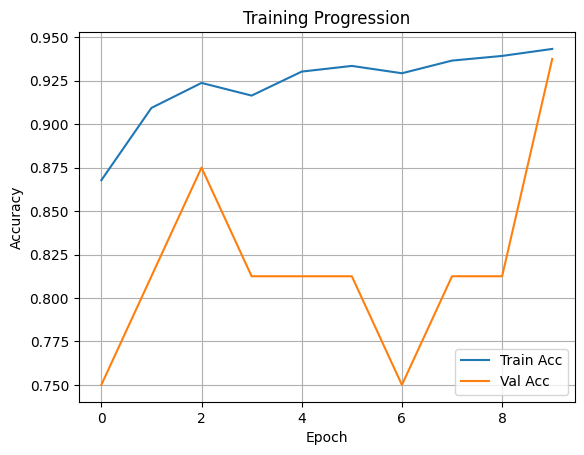

In [31]:
plt.plot(history_aug.history['accuracy'], label='Train Acc')
plt.plot(history_aug.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Progression')
plt.legend()
plt.grid(True)
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step


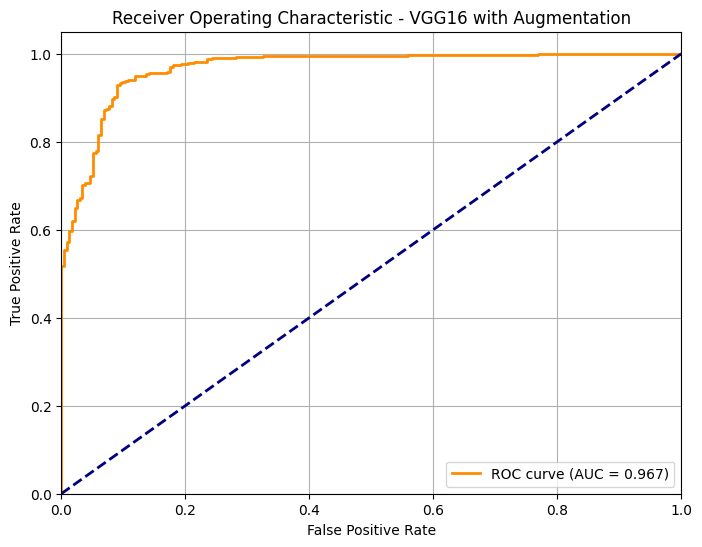

In [32]:
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predicted probabilities
y_true = test_generator.classes
y_pred_probs = vgg_aug.predict(test_generator)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - VGG16 with Augmentation')
plt.legend(loc="lower right")
plt.grid()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.86      0.91      0.89       234
   PNEUMONIA       0.94      0.91      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624


Accuracy Score: 0.9119


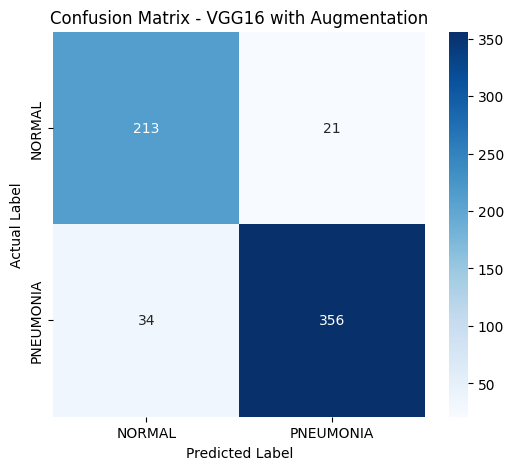

In [33]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
y_true = test_generator.classes

# Predicted probabilities
y_pred_probs = vgg_aug.predict(test_generator)

# Convert probabilities to class labels (threshold = 0.5)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy score
acc = accuracy_score(y_true, y_pred_classes)
print(f"\nAccuracy Score: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix - VGG16 with Augmentation')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import cv2

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=0)
    return img_array, img

def grad_cam(model, grad_model, img_array):
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    pooled_grads = pooled_grads.numpy()
    conv_output = conv_output.numpy()

    heatmap = np.dot(conv_output, pooled_grads)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap + 1e-8)  # prevent division by 0
    heatmap = cv2.resize(heatmap, (224, 224))

    return heatmap

def display_grad_cam(img_path, model, grad_model):
    img_array, original_img = preprocess_image(img_path)
    heatmap = grad_cam(model, grad_model, img_array)

    plt.imshow(original_img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Grad-CAM')
    plt.show()


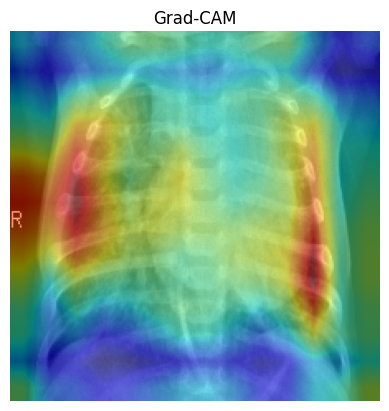

In [36]:
img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
display_grad_cam(img_path, vgg_aug, grad_model_aug)
